In [1]:
!pip install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import kagglehub
# Download latest version
# path = kagglehub.dataset_download("uciml/iris.csv")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [4]:
class FuzzyDecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2, k=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.tree = None
        
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        data = np.hstack([X, y.reshape(-1,1)])
        self.tree = self._build_tree(data, depth=0)
    
    def _build_tree(self, data, depth):
        if depth == self.max_depth or len(data) < self.min_samples_split:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}
        
        best_feature = None
        best_threshold = None
        best_impurity = np.inf
        best_split = None
        n_features = data.shape[1] - 1
        
        for feature in range(n_features):
            values = data[:, feature]
            unique_vals = np.unique(values)
            if len(unique_vals) == 1:
                continue
                
            candidate_thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
            for threshold in candidate_thresholds:
                left_weights = 1 / (1 + np.exp(self.k * (data[:, feature] - threshold)))
                right_weights = 1 - left_weights
                total_left = np.sum(left_weights)
                total_right = np.sum(right_weights)
                
                if total_left < 1e-6 or total_right < 1e-6:
                    continue
                
                left_distribution = {}
                right_distribution = {}
                for c in range(self.n_classes):
                    mask = (data[:,-1] == c)
                    w_left = np.sum(left_weights[mask])
                    w_right = np.sum(right_weights[mask])
                    left_distribution[c] = w_left
                    right_distribution[c] = w_right
                
                left_total = np.sum(list(left_distribution.values()))
                right_total = np.sum(list(right_distribution.values()))
                impurity_left = 1 - np.sum((np.array(list(left_distribution.values()))/left_total)**2) if left_total > 0 else 0
                impurity_right = 1 - np.sum((np.array(list(right_distribution.values()))/right_total)**2) if right_total > 0 else 0
                weighted_impurity = (left_total * impurity_left + right_total * impurity_right) / (left_total + right_total)
                
                if weighted_impurity < best_impurity:
                    best_impurity = weighted_impurity
                    best_feature = feature
                    best_threshold = threshold
                    best_split = (left_weights, right_weights)
        
        if best_feature is None:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}
        
        # Жесткое разбиение (заполненный пропуск)
        left_mask = data[:, best_feature] < best_threshold
        right_mask = ~left_mask
        
        left_tree = self._build_tree(data[left_mask], depth + 1)
        right_tree = self._build_tree(data[right_mask], depth + 1)
        
        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }
    
    def _predict_sample(self, x, node):
        if node['is_leaf']:
            return node['class_distribution']
        
        feature = node['feature']
        threshold = node['threshold']
        left_weight = 1 / (1 + np.exp(self.k * (x[feature] - threshold)))
        right_weight = 1 - left_weight
        
        left_pred = self._predict_sample(x, node['left'])
        right_pred = self._predict_sample(x, node['right'])
        
        combined = {}
        for c in range(self.n_classes):
            combined[c] = left_weight * left_pred.get(c, 0) + right_weight * right_pred.get(c, 0)
        return combined
    
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            distribution = self._predict_sample(X[i], self.tree)
            pred_class = max(distribution, key=distribution.get)
            preds.append(pred_class)
        return np.array(preds)

In [5]:
class FuzzyRandomForest:
    def __init__(self, n_estimators=10, max_depth=3, min_samples_split=2, k=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.trees = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            tree = FuzzyDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                k=self.k
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions)
        final_predictions, _ = mode(predictions, axis=0)
        return final_predictions.flatten()

In [6]:
def print_tree(node, indent=""):
    if node['is_leaf']:
        print(indent + "Лист:", {k: round(v, 2) for k, v in node['class_distribution'].items()})
    else:
        print(indent + f"Разбиение: feature[{node['feature']}] < {node['threshold']:.2f}")
        print(indent + " -> Левая ветка:")
        print_tree(node['left'], indent + " ")
        print(indent + " -> Правая ветка:")
        print_tree(node['right'], indent + " ")

In [8]:
# path = 'C:\\Users\\aerty\\.cache\\kagglehub\\datasets\\uciml\\iris\\versions\\2'
path = ''
data_path = path + 'iris.csv'
df = pd.read_csv(data_path, sep=',', index_col = 'Id')
# df.columns = [ "SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm", "Species"]

print("Первые строки датасета:")
print(df.head())

features = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
X = df[features].values

le = LabelEncoder()
y = le.fit_transform(df['Species'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Первые строки датасета:
    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
Id                                                                       
1             5.1           3.5            1.4           0.2  Iris-setosa
2             4.9           3.0            1.4           0.2  Iris-setosa
3             4.7           3.2            1.3           0.2  Iris-setosa
4             4.6           3.1            1.5           0.2  Iris-setosa
5             5.0           3.6            1.4           0.2  Iris-setosa


In [9]:
# Параметры модели
n_estimators = 5
max_depth = 3
min_samples_split = 5
k = 10

# Обучение нечеткого леса 
fuzzy_forest = FuzzyRandomForest(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    k=k
)
fuzzy_forest.fit(X_train, y_train)

# Предсказание и оценка
y_pred_fuzzy = fuzzy_forest.predict(X_test)
print("\nНечеткий лес:")
print("Accuracy:", accuracy_score(y_test, y_pred_fuzzy))
print(classification_report(y_test, y_pred_fuzzy))

# Предсказание и оценка(train)
y_pred_fuzzy = fuzzy_forest.predict(X_train)
print("\nНечеткий лес (train):")
print("Accuracy:", accuracy_score(y_train, y_pred_fuzzy))
print(classification_report(y_train, y_pred_fuzzy))

# Сравнение с классическим случайным лесом 
rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("\nКлассический случайный лес:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

#train

y_pred_rf = rf.predict(X_train)
print("\nКлассический случайный лес (train):")
print("Accuracy:", accuracy_score(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf))


Нечеткий лес:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Нечеткий лес (train):
Accuracy: 0.9619047619047619
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.97      0.92      0.94        37
           2       0.92      0.97      0.95        37

    accuracy                           0.96       105
   macro avg       0.96      0.96      0.96       105
weighted avg       0.96      0.96      0.96       105


Классический случайный лес:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
     

In [10]:
print("\nСтруктура каждого нечеткого дерева в лесу:")
for i, tree in enumerate(fuzzy_forest.trees):
    print(f"\n=== Дерево {i+1} ===")
    print_tree(tree.tree)


Структура каждого нечеткого дерева в лесу:

=== Дерево 1 ===
Разбиение: feature[2] < 2.45
 -> Левая ветка:
 Разбиение: feature[0] < 4.55
  -> Левая ветка:
  Лист: {0.0: 1.0}
  -> Правая ветка:
  Разбиение: feature[0] < 4.75
   -> Левая ветка:
   Лист: {0.0: 1.0}
   -> Правая ветка:
   Лист: {0.0: 1.0}
 -> Правая ветка:
 Разбиение: feature[2] < 4.80
  -> Левая ветка:
  Разбиение: feature[0] < 5.00
   -> Левая ветка:
   Лист: {1.0: 1.0}
   -> Правая ветка:
   Лист: {1.0: 1.0}
  -> Правая ветка:
  Разбиение: feature[3] < 1.65
   -> Левая ветка:
   Лист: {1.0: 0.6, 2.0: 0.4}
   -> Правая ветка:
   Лист: {1.0: 0.04, 2.0: 0.96}

=== Дерево 2 ===
Разбиение: feature[2] < 2.70
 -> Левая ветка:
 Разбиение: feature[0] < 4.35
  -> Левая ветка:
  Лист: {0.0: 1.0}
  -> Правая ветка:
  Разбиение: feature[0] < 4.45
   -> Левая ветка:
   Лист: {0.0: 1.0}
   -> Правая ветка:
   Лист: {0.0: 1.0}
 -> Правая ветка:
 Разбиение: feature[2] < 5.05
  -> Левая ветка:
  Разбиение: feature[3] < 1.60
   -> Левая 

<Axes: >

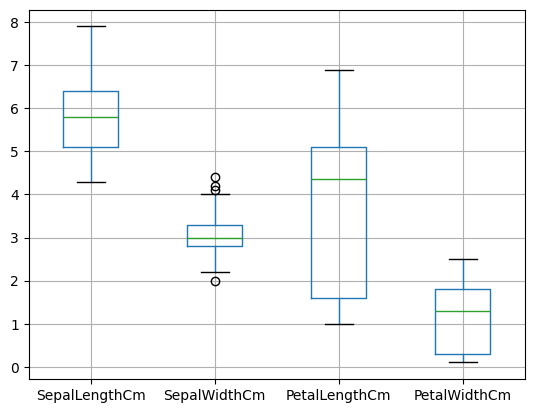

In [11]:
df.boxplot()

In [16]:
sns.histplot(data=df, x='Species', fill=True, binwidth=1)

<Axes: xlabel='Species', ylabel='Count'>

In [17]:
X = df.drop('Species', axis=1).values
y = df['Species'].values
X.shape, y.shape

((150, 4), (150,))

In [18]:
sns.histplot(y, fill=True, binwidth=1)

<Axes: xlabel='Species', ylabel='Count'>